In [1]:
import torch 
import pandas as pd
import numpy as np 

from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
#Lets check for GPU usage in the notebook
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("GPU is available")
else:
    print("CPU is available")

GPU is available


# Lets Look at Our Data 

This will comprise of:
* Preproccessing data
* Loading Data
* Then finally visualizing a batch of data 


This is the typical difference between a normal lung and pneumonia lung
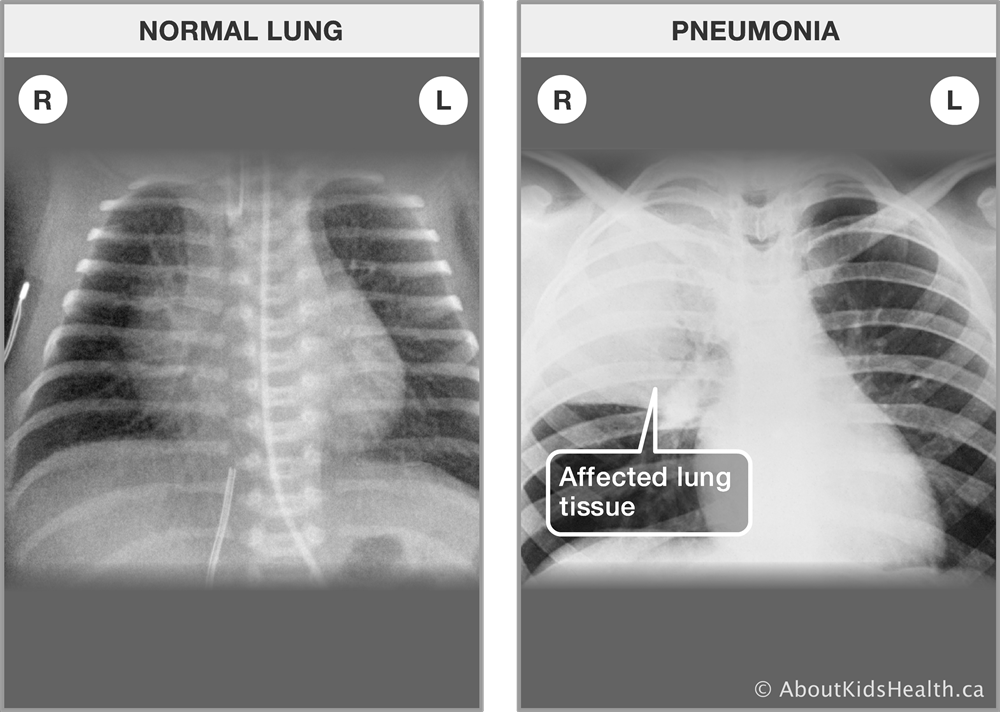



In [3]:
#Lets Define a a root directory that will load the data and also classes. 

root_dir = "../input/chest-xray-pneumonia/chest_xray/"
classes = ['NORMAL', 'PNEUMONIA']

#Define general parameters
batch_size = 20
num_workers = 0

#Lets start to load our actual data in now
# Lets define transforms

#For the learning_transforms lets add data augmentation
learning_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.2),
                                          transforms.RandomRotation(30),
                                          transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#For the testing_transforms lets add data augmentation
testing_transforms = transforms.Compose([transforms.Resize(255),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(root_dir + "train/", transform = learning_transforms)
valid_data = datasets.ImageFolder(root_dir + "val/", transform = learning_transforms)
test_data = datasets.ImageFolder(root_dir + "test/", transform = testing_transforms)

#Generators to load in batch_size amount of images

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)


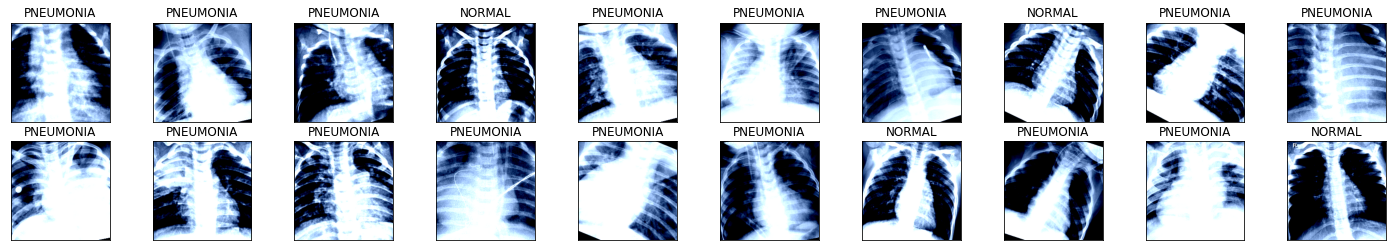

In [4]:
dateiter = iter(train_loader)
images, labels = dateiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


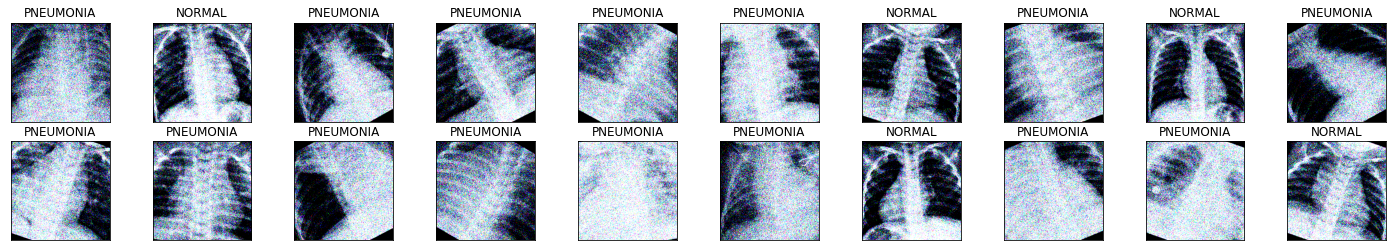

In [5]:
#We can see noisy images of the above 
noise_factor = 0.6

noisy_dateiter = iter(train_loader)
images, labels = next(noisy_dateiter)

noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(noisy_imgs[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

    

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        
        total_pixels = 14 * 14 * 128
        self.fc1 = nn.Linear(total_pixels, 784)
        self.fc2 = nn.Linear(784, 2)
        
        self.maxPool = nn.MaxPool2d(2, 2)

        self.batchnorm12d = nn.BatchNorm2d(32)
        self.batchnorm22d = nn.BatchNorm2d(128)
        
        self.batchnorm1d = nn.BatchNorm1d(784)
        self.dropout = nn.Dropout(p = 0.3)
    
    def forward(self, x):
        
        x = self.maxPool(F.relu(self.conv1(x)))
        x = self.maxPool(F.relu(self.conv2(x)))
        x = self.batchnorm12d(x)
        x = self.maxPool(F.relu(self.conv3(x)))
        x = self.maxPool(F.relu(self.conv4(x)))
        x = self.batchnorm22d(x)
        
        x = x.view(-1, 14 * 14 * 128)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.batchnorm1d(x)
        x = self.fc2(x)
        
        return x
        
model = Predictor()
print(model)

Predictor(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=25088, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=2, bias=True)
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm12d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm22d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm1d): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [41]:
from torch import optim
lr = 0.03
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [42]:
def train(model, optimizer, criterion, epochs, trainloader, validloader):
    
    counter = 0
    
    if use_cuda:
        model.cuda()
    
    for e in range(1, epochs + 1):
        
        counter += 1
        
        train_loss = 0
        valid_loss = 0
        
        model.train()
        for batch_idx, (data, label) in enumerate(trainloader):
            
            if use_cuda:
                data, label = data.cuda(), label.cuda()
                
            #We need to zero out gradients
            optimizer.zero_grad()
            #Forward through the network
            output = model(data)
            #Calculate the loss using criterion
            loss = criterion(output, label)
            #Backpropagate the loss
            loss.backward()
            #Lets then perform GD
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        for batch_idx, (data, label) in enumerate(validloader):
            
            if use_cuda:
                data, label = data.cuda(), label.cuda()
            
            #Forward through the network
            output = model(data)
            #Calculate the loss using criterion
            loss = criterion(output, label)
            
            valid_loss += loss.item()
        
        print("Epoch: ", counter, "Train loss: ", train_loss, "Valid Loss: ", valid_loss)       

In [43]:
train(model, optimizer, criterion, 6, train_loader, valid_loader)

Epoch:  1 Train loss:  144.83117839787155 Valid Loss:  1697.7996826171875
Epoch:  2 Train loss:  79.81329475494567 Valid Loss:  1.0497028827667236
Epoch:  3 Train loss:  45.1771802790463 Valid Loss:  0.8862305879592896
Epoch:  4 Train loss:  45.43197587283794 Valid Loss:  0.477193683385849


KeyboardInterrupt: 

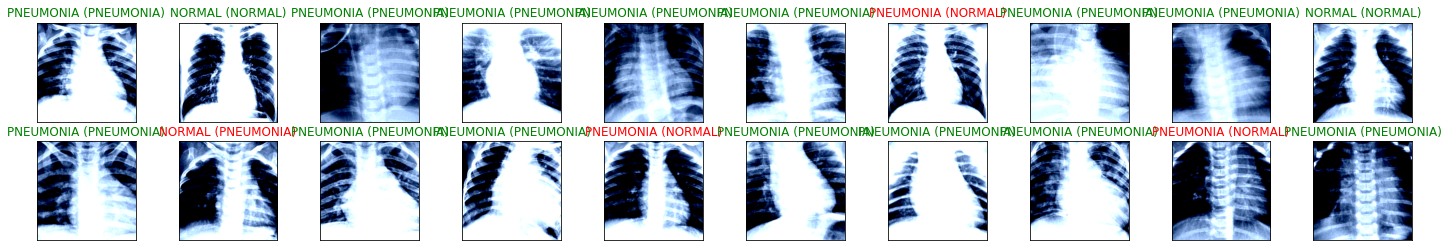

In [46]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
images = images.cpu()
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [34]:
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        
        #Condensed the image
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding = 1)
        self.conv4 = nn.Conv2d(16, 8, 3, padding = 1)
        
        self.maxpool = nn.MaxPool2d(3, 2, padding = 1)
        self.batchnorm = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(8)
        
        #Upscale the image 
        self.convt1 = nn.ConvTranspose2d(8, 16, 2, 2)
        self.convt2 = nn.ConvTranspose2d(16, 32, 2, 2)
        self.convt3 = nn.ConvTranspose2d(32, 64, 2, 2)
        self.convt4 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.conv5 = nn.Conv2d(64, 3, 3, padding = 1)
        
        self.batchnormt = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        #Downscaling the image
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        
        x = self.batchnorm(x)
        
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        
        x = self.batchnorm2(x)
        
        #Upscale the image
        x = F.relu(self.convt1(x))
        x = F.relu(self.convt2(x))
        x = self.batchnormt(x)
        x = F.relu(self.convt3(x))
        x = F.relu(self.convt4(x))
        
        x = self.batchnorm3(x)
        x = torch.sigmoid(self.conv5(x))
        
        return x
    
denoiser = ConvDenoiser()
print(denoiser)

ConvDenoiser(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt1): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (convt2): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (convt3): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (convt4): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnormt): BatchNorm2d(32, eps=1e-05, 

In [35]:
denoiser_optimizer = optim.Adam(denoiser.parameters(), lr = lr)
denoiser_criterion = nn.MSELoss()

In [36]:
def denoise(denoiser, criterion, optimizer, epochs, trainloader, validloader):
    
    if use_cuda:
        denoiser.cuda()
    
    counter = 0
    
    for epoch in range(1, epochs+1):
        
        counter += 1
        train_loss = 0
        valid_loss = 0
        
        for images, _ in trainloader:
            
            noisy_imgs = images + noise_factor * torch.randn(*images.shape)
            noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            
            if use_cuda:
                images = images.cuda()
                noisy_imgs = noisy_imgs.cuda()
            
            optimizer.zero_grad()
            output = denoiser(noisy_imgs)
            loss = criterion(output, images)
            optimizer.step()
            
            train_loss += loss.item()
        
        for images, _ in validloader:
            
            noisy_imgs = images + noise_factor * torch.randn(*images.shape)
            noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            
            if use_cuda:
                images = images.cuda()
                noisy_imgs = noisy_imgs.cuda()
            
            output = denoiser(noisy_imgs)
            loss = criterion(output, images)
            
            valid_loss += loss.item()
            
        print("Epoch: ", counter, "Train Loss: ", train_loss, "Valid_loss: ", valid_loss)


In [37]:
denoise(denoiser, denoiser_criterion, denoiser_optimizer, 6, train_loader, valid_loader)

Epoch:  1 Train Loss:  173.2672354578972 Valid_loss:  0.7110555171966553
Epoch:  2 Train Loss:  172.72054505348206 Valid_loss:  0.7548026442527771
Epoch:  3 Train Loss:  172.53406238555908 Valid_loss:  0.6837215423583984
Epoch:  4 Train Loss:  172.80740347504616 Valid_loss:  0.7216542363166809


KeyboardInterrupt: 

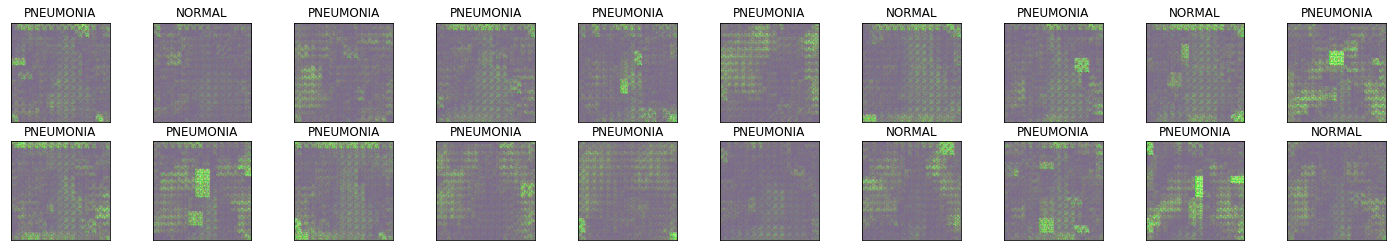

In [38]:
dateiter = iter(test_loader)
images, _ = dateiter.next()

noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

if use_cuda:
    noisy_imgs = noisy_imgs.cuda()

output = denoiser(noisy_imgs)
noisy_imgs = noisy_imgs.cpu()
noisy_imgs = noisy_imgs.numpy()

output = output.cpu()
output = output.detach().numpy()


# input images on top row, reconstructions on bottom
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(output[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Implement Transfer Learning
        
**We Have to first load in the resnet model**

**Then we have to train, validate, and then test the model**

In [54]:
resnet = models.resnet50(pretrained = True)


for param in resnet.parameters():
    param.requires_grad = False 


resnet.fc = nn.Linear(resnet.fc.in_features, 2)
print(resnet)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [55]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(resnet.fc.parameters(), lr = 0.01)


In [56]:
epochs = 6
print_every = 500
if use_cuda:
    resnet.cuda()

for e in range(1, epochs + 1):
    
    train_loss = 0
    valid_loss = 0
    
    resnet.train()
    for batch_idx, (images, label) in enumerate(train_loader):
        
        if use_cuda:
            images, label = images.cuda(), label.cuda()
        
        optimizer.zero_grad()
        
        output = resnet(images)
        loss = criterion(output, label)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        
        if batch_idx % print_every == 1:
            print("Train Loss: ", train_loss)
    
    resnet.eval()
    for batch_idx, (images, label) in enumerate(valid_loader):
        
        if use_cuda:
            images, label = images.cuda(), label.cuda()
        
        output = resnet(images)
        loss = criterion(output, label)
        
        valid_loss += valid_loss
    
    print(valid_loss)
    
    
            


Train Loss:  6.324125230312347


KeyboardInterrupt: 

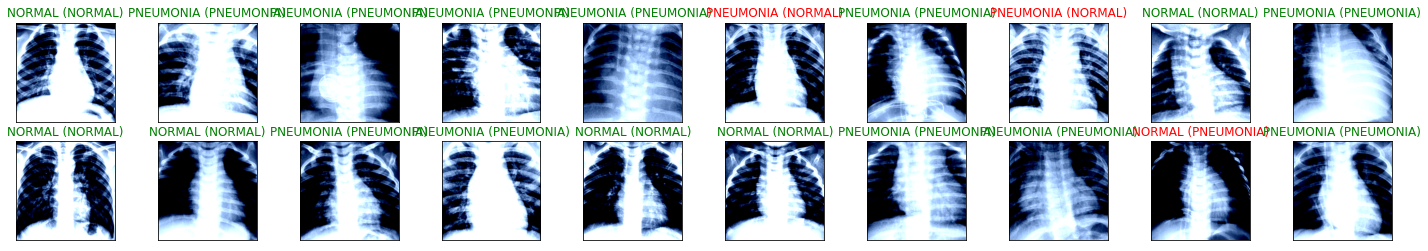

In [96]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = resnet(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
images = images.cpu()
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [71]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [132]:
from PIL import Image
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

def predict(img_path):
    def preprocess(img_path):
    
        image = Image.open(img_path).convert("RGB")
    
        transform = transforms.Compose([transforms.Resize(255),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
        image = transform(image)[:3, :, :].unsqueeze(0)
        return image 
    
    image = preprocess(img_path)
    
    #We squeezed the image to plot the (3, 224, 224) image
    image = image.squeeze()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    
    #We unsqueezed the image to pass the (1, 3, 224, 224) image in network
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    output = resnet(image)
    
    for value in output:
        value = value.cpu().detach().numpy()
        
    if value[1] < 0.80:
        print("This is a normal x-ray")
    else:
        print("Treat him! He has pneomonia")
                





Treat him! He has pneomonia


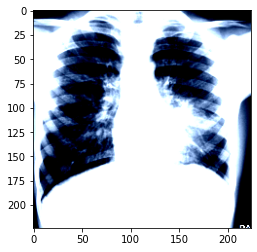

In [133]:
predict("../input/predict-files/pneumonia.jpeg")

This is a normal x-ray


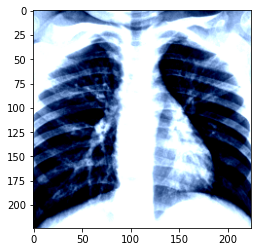

In [134]:
predict("../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0009-0001.jpeg")

This is a normal x-ray


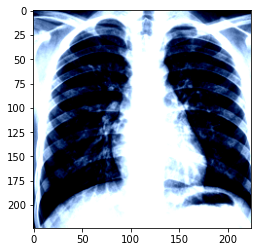

In [135]:
predict("../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0031-0001.jpeg")

This is a normal x-ray


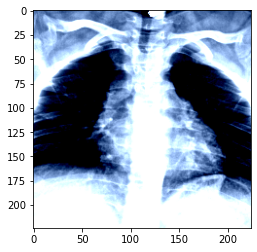

In [136]:
predict("../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0050-0001.jpeg")

Treat him! He has pneomonia


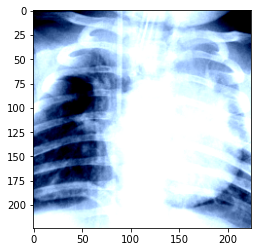

In [137]:
predict("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg")

# Now we are going to try other diseases X-rays from other diseases


This is a normal x-ray


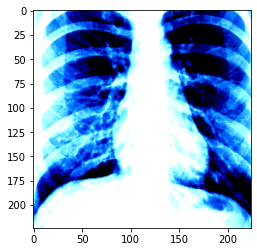

In [139]:
predict("../input/predictfiles/lungcancer.jpg")

This is a normal x-ray


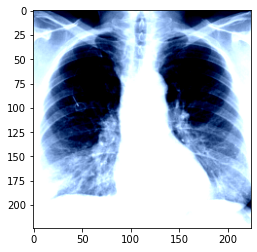

In [140]:
predict("../input/predictfiles/covid.jpg")

Let me Predict with my model

In [155]:
def my_predict(img_path):
    def preprocess(img_path):
    
        image = Image.open(img_path).convert("RGB")
    
        transform = transforms.Compose([transforms.Resize(255),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
        image = transform(image)[:3, :, :].unsqueeze(0)
        return image 
    
    image = preprocess(img_path)
    
    #We squeezed the image to plot the (3, 224, 224) image
    image = image.squeeze()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    
    #We unsqueezed the image to pass the (1, 3, 224, 224) image in network
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    output = resnet(image)
    
    for value in output:
        value = value.cpu().detach().numpy()
        
    if value[1] < 0.80:
        print("This is a normal x-ray")
    else:
        print("Treat him! He has pneomonia")

This is a normal x-ray


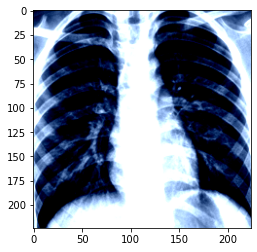

In [157]:
my_predict("../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0046-0001.jpeg")

Treat him! He has pneomonia


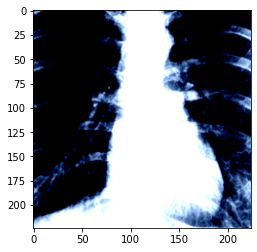

In [158]:
my_predict("../input/predictfiles/pneumonia2.jpg")

Treat him! He has pneomonia


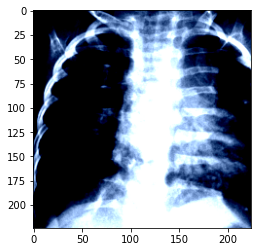

In [159]:
my_predict("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person103_bacteria_490.jpeg")

Treat him! He has pneomonia


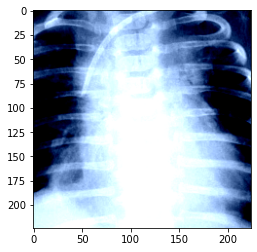

In [160]:
my_predict("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_526.jpeg")

# Final Test is to put in the autoencoded Data and see what happens

Treat him! He has pneomonia
Correct autencoded image


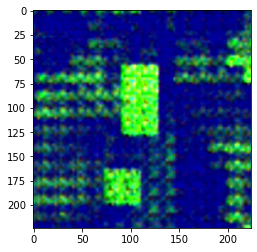

In [161]:
my_predict("../input/autoencoded/Screen Shot 2020-08-23 at 8.06.02 PM.png")
print("Correct autencoded image")

This is a normal x-ray
This is wrong


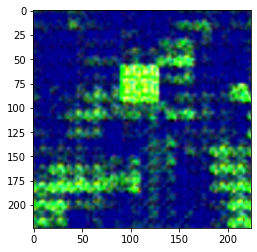

In [163]:
my_predict("../input/autoencoded/Screen Shot 2020-08-23 at 8.06.32 PM.png")
print("This is wrong")

This is a normal x-ray


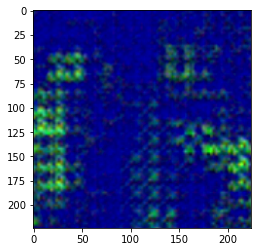

In [166]:
my_predict("../input/autoencoded/Screen Shot 2020-08-23 at 8.06.37 PM.png")
print("This is correct")